## Data Stories

Let's have some fun poking around the data.  

Contents:
1. imports
2. ecdf, min_1_50_99_max
    * todo: rename that fn min015099max
3. load data
4. check index for nulls
5. peek at data
6. ensure sorted index
7. info
8. drop empty cols
9. check
10. assign
11. plot cost_per_watt vs data
12. make mdf for linear regression
13. lose rows with null values
14. peek at mdf
15. reset the index (for consecutive.
16. lose old index
17. peek again
18. build series days: days since day0
19. new col for mdf name: ndays, content: days
20. peek
21. sns.lmplot model
22. fit with ols
23. sns.pairplot
24. sns lmplot cost and size
25. fit with ols - $R^2$ is strong

### Start by loading up

In [1]:
# I need a python setup file.

# set up
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set()
%matplotlib inline

C:\Users\saus\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n
    return x, y

def min_1_50_99_max(series):
    vals = list(np.percentile(series, [1.0, 50.0, 99.0]))
    vals.insert(-1, series.max())
    vals.insert(0, series.min())
    return vals

# ss = np.arange(1, 101)
# min_1_50_99_max(ss)                

In [3]:
# load df
utils = pd.read_csv('../local/data/utilities.csv', index_col='date_installed', parse_dates=True)

In [4]:
# index has no nulls
utils.index.isnull().sum()

0

In [5]:
utils.head()

,state,incentive_prog_names,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,cost,lbnl_tts_version_year,...,reported_annual_energy_prod,year,pbi_length,utility,bipv_3,bipv_2,bipv_1,new_constr,tracking,3rdparty
date_installed,,,,,,,,,,,,,,,,,,,,,
1997-11-18,NY,NaN,5.50,NaN,10601,utility,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-11-12,NY,NaN,7.56,NaN,10546,utility,NaN,7.67,58000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-06,TN,NaN,15.00,NaN,37923,utility,NaN,10.00,150000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-02,WA,NaN,38.70,NaN,99353,utility,NaN,7.26,281000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-18,FL,NaN,10.00,NaN,32614,utility,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# make sure it's in order
utils.sort_index(inplace=True)

In [7]:
# lots of null cols
# 230 rows, 66 with cost and cost_per_watt
# the rest are just informational
utils.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230 entries, 1997-11-18 to 2015-09-25
Data columns (total 37 columns):
state                          230 non-null object
incentive_prog_names           0 non-null float64
size_kw                        230 non-null float64
appraised                      0 non-null float64
zipcode                        230 non-null int64
install_type                   230 non-null object
installer                      2 non-null object
cost_per_watt                  66 non-null float64
cost                           66 non-null float64
lbnl_tts_version_year          0 non-null float64
lbnl_tts                       0 non-null float64
city                           11 non-null object
utility_clean                  0 non-null float64
tech_1                         0 non-null float64
model1_clean                   0 non-null float64
county                         195 non-null object
annual_PV_prod                 0 non-null float64
annual_insolation   

In [8]:
# drop all the empty columns
tmp = utils.dropna(how='all', axis=1)

In [9]:
# and check.  
tmp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230 entries, 1997-11-18 to 2015-09-25
Data columns (total 9 columns):
state            230 non-null object
size_kw          230 non-null float64
zipcode          230 non-null int64
install_type     230 non-null object
installer        2 non-null object
cost_per_watt    66 non-null float64
cost             66 non-null float64
city             11 non-null object
county           195 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 18.0+ KB


In [10]:
# ok, looks good; now we're down to a nice little set of variables; lock it in.
utils = tmp

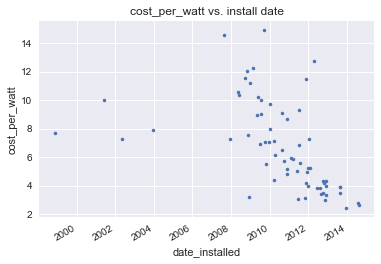

In [11]:
# this is so nice I want to regress it right away though outliers may be a problem.
utils.cost_per_watt.plot(marker='.', linestyle='none')
plt.title('cost_per_watt vs. install date')
plt.ylabel('cost_per_watt')
plt.xlabel('date_installed');

#### Set up df for linear regression

In [12]:
mdf = pd.DataFrame({'date_installed' : pd.Series(utils.index),
                    'cost_per_watt'   : pd.Series(utils.cost_per_watt.values)})

In [13]:
# get rid of null values
mdf.dropna(how='any', inplace=True)

In [14]:
mdf.head()

,cost_per_watt,date_installed
1,7.67,1998-11-12
2,10.00,2001-06-06
3,7.26,2002-05-02
5,7.87,2003-12-24
7,14.55,2007-08-23


In [15]:
mdf.reset_index(level=0, inplace=True); mdf.head()

,index,cost_per_watt,date_installed
0,1,7.67,1998-11-12
1,2,10.00,2001-06-06
2,3,7.26,2002-05-02
3,5,7.87,2003-12-24
4,7,14.55,2007-08-23


In [16]:
# get rid of old index
mdf.drop('index', axis='columns', inplace=True)

In [17]:
mdf.head()

,cost_per_watt,date_installed
0,7.67,1998-11-12
1,10.00,2001-06-06
2,7.26,2002-05-02
3,7.87,2003-12-24
4,14.55,2007-08-23


In [18]:
# add a column that is number of days after 1998-11-12
day0 = pd.to_datetime('1998-11-12')
days = (mdf.date_installed - day0).apply(lambda x: x.days)
days.head()

0       0
1     937
2    1267
3    1868
4    3206
Name: date_installed, dtype: int64

In [19]:
mdf = mdf.assign(ndays = days)

In [20]:
mdf.head()

,cost_per_watt,date_installed,ndays
0,7.67,1998-11-12,0
1,10.00,2001-06-06,937
2,7.26,2002-05-02,1267
3,7.87,2003-12-24,1868
4,14.55,2007-08-23,3206


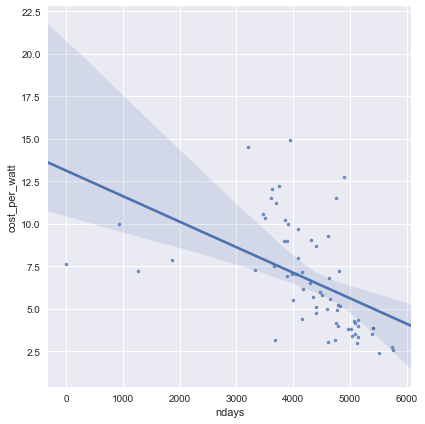

In [21]:
# like I thought, not a real powerful model, but maybe not useless.
sns.lmplot('ndays', 'cost_per_watt', mdf, size=6, markers='.')

In [22]:
# 
# okay, this says you pay $1.50 less for every 1000 days you wait, or about $0.50/watt less per year
# 

m = ols('cost_per_watt ~ ndays', mdf).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:          cost_per_watt   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     21.06
Date:                Wed, 27 Dec 2017   Prob (F-statistic):           2.14e-05
Time:                        22:19:32   Log-Likelihood:                -159.29
No. Observations:                  66   AIC:                             322.6
Df Residuals:                      64   BIC:                             327.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1396      1.434      9.162      0.0

### Check relationship cost, size, cost_per_watt

Should be linear.

####  Pair plot

Let's see what pair plot shows us.

In [23]:
utils.describe()

,size_kw,zipcode,cost_per_watt,cost
count,230.000000,230.000000,66.000000,6.600000e+01
mean,7813.015487,52276.147826,6.744091,1.564180e+07
std,23593.192729,33723.885321,3.140749,2.888603e+07
min,0.900000,1007.000000,2.430000,1.150000e+04
25%,517.693750,19947.750000,4.040000,6.879875e+04
50%,2164.600000,47485.000000,6.075000,3.979253e+06
75%,8165.000000,87089.500000,9.002500,1.184034e+07
max,333000.000000,99353.000000,14.940000,1.522000e+08


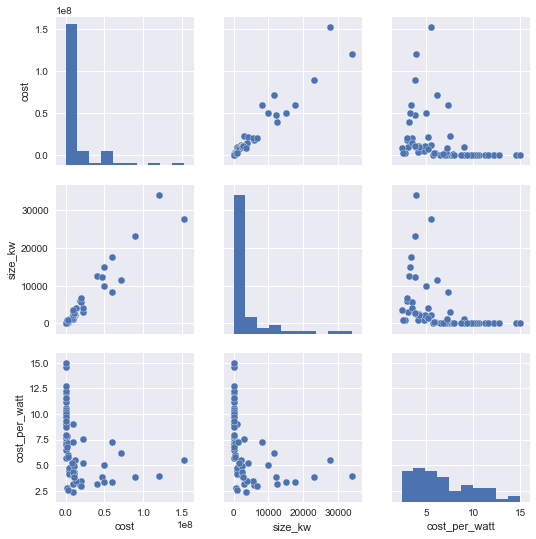

In [24]:
# maybe blowing up because of null values
# masking nulls makes it go
sns.pairplot(utils[utils.cost.notnull()][['cost', 'size_kw', 'cost_per_watt']]);

### Interpretation of the above plots

We expect to see a linear relationship between cost and size.  If you pay more, you should get more and vice versa.  If the cost per watt changes over time then we would see divergence from a pure linear function.

We might expect to see price drop as size increases.  The plot above doesn't say either way.  It's not surpising as the data set is tiny and time is not taken into account.

In fact, when we model, we are going to want to be careful with cost and size because they are linearly related.  The target, cost_per_size, may have meaningful relationships with time (component price reduction over time) and size (economy of scale).  Thus cost is the best candidate for leaving out.

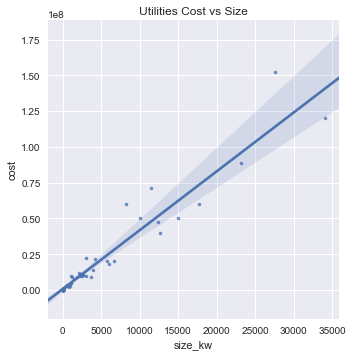

In [25]:
# I predict this will give me back the mean cost_per_watt as the slope
sns.lmplot( 'size_kw', 'cost', utils[utils.cost.notnull()], markers='.')
plt.title('Utilities Cost vs Size');

In [26]:
# 
# okay, the model says you pay $4k for every kwatt you add.
# 

m = ols('cost ~ size_kw', utils[utils.cost.notnull()]).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     792.5
Date:                Wed, 27 Dec 2017   Prob (F-statistic):           9.22e-38
Time:                        22:19:33   Log-Likelihood:                -1141.4
No. Observations:                  66   AIC:                             2287.
Df Residuals:                      64   BIC:                             2291.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.048e+05   1.12e+06      0.542      0.5

#### These cells gave me the idea to focus in on utilities.  Left here as comments for documentation.

In [27]:
# I wonder if this copies the data or just gives you an array of pointers to it?
# bySize = dfFull.sort_values(['size_kw'])

In [28]:
# 88733345.0/1000000

In [29]:
# okay everyone is a utility except for 2 bad data from Roseville CA.
# and every is null everywhere except for size.  Wait there's 1 priced entry in TX
# $89M @ 3.84/watt in 2012
# bySize.tail(24)

In [30]:
# let's look at all the 'utility's

In [31]:
### Okay, light bulb goes on.  Since this is a nice little set of data we can save it out
### on its own and science the shit out of it.  Also has the charactistic that many fields
### are null and can be dropped.utils = dfFull[dfFull.install_type == 'utility']


In [32]:
# df.describe's default behavior is to show stats for numeric fields.  That's nice in this case 
# because it's expose some of the fields as particularly useless.
# Let's begin to list candidates for dropping to reduce cognitive load.
# utils.describe()

In [33]:
# utils.to_csv('../local/data/utilities.csv')